## Name : Pat O'Dowd
## Number : 8273375

#Variational Autoencoder
The goal of this assignment is to train a variational autoencoder on the MNIST dataset. The performance of the trained autoencoder is assessed via:
* Reconstruction of input images.
* Generation of novel samples.
* Clustering in latent space.

The notebook below contains code to assist with dataloading, training and plotting of reconstructed and generated images.
* You will need to implement the VAE model in pytorch and also setup the loss function for training. Slight modification of the training loop may be required, depending on your exact architecture.  


A typical VAE consists of an encoder and decoder block (as shown in figure (a)). ![](https://github.com/tonyscan6003/etivities/blob/main/CE5012_A-Page-4%20(16).jpg?raw=true)

In theory the encoder learns a mapping (approximation to the posterior) $q(\bf{z}|\bf{x},\phi)=\aleph(\bf{z}|g(\bf{x},\phi))$ from the input distribution to a normally distributed latent space $P(z)=\aleph(0,I)$. And the decoder outputs the likelihood $P(\bf{x}|\bf{z},\theta)=\aleph(\bf(x)|f(\bf{z},\theta),\sigma^2I)$ of a sample $\bf{z^{(i)}}$ from the encoder (approximation to the posterior). (we note that the encoder and decoder mappings are normal distributions).

The Variational autoencoder is trained by maximising the ELBO (evidence based lower bound)
$ELBO_{\theta,\phi}=log P(\bf{x}|\bf{z},\theta)-D_{KL}[q(\bf{z}|\bf{x},\phi)||P(\bf{x}|\bf{z},\theta)]$
where $D_{KL}$ is the kullback leibler divergence.

 In practice for training the VAE is implemented as a sampled system. The "reparameterisation trick" must be employed during training, as it is not possible to perform backpropagation through the sampling stage shown in figure (a), instead as shown in figure (b) we can directly sample $\bf{\epsilon}$ from the normal distribution with mean zero and standard deviation 1 and simply multiply the variance and add the mean (determined by the enocder) to the drawn sample. $\bf{z^{(i)}}=\bf{\mu{(i)}}+\bf{\sigma{(i)}}\odot\epsilon$ (note that all quantities $\bf{\mu{(i)}}$,$\bf{\sigma{(i)}}$ and $\bf{\epsilon}$ have the same dimension as the latent space $J$)

In this specific case where we are trainig with the MNIST dataset. The decoders task can be interpreted as predicting the likelihood of a binary value at each spatial position, then in this case the log likelihood $P(\bf{x}|\bf{z},\theta)$ can be interpreted as the multivariate Bernoulli Distribution. (note that this is different to the case in the video lessons which instead obtains a MSE error for cases with 3 channel colour images)
The log likeihood is interpreted as a reconstruction loss term and is given by $\mathcal{L}_{rec}=log P(\bf{x}|\bf{z},\theta)=\sum_{i=1}^Dx_ilog (y_i)+(1-x_i)log(1-yi)$
We recognise the equation on the right as the familiar binary cross entropy loss, that is summed over the total spatial dimensions $D$ and each $\bf{y}$ is the output of the decoder network (same dimensions as the encoder input $\bf{x}$.

 The KL divergence term can be simplified when it is assumed that the prior  $P(z)=\aleph(0,I)$ is a normally distributed gaussian and the posterior approximation for each input consists of multivariate independent gaussians: $q(\bf{z}|\bf{x^{(i)}},\phi)=\aleph(\bf{z}|g(\bf{x^{(i)}},\phi))=\aleph(z; bf{\mu^{(i)}},\bf{\sigma^{2(i)}I})$. Where $g(\bf{x^{(i)}},\phi)$ is the output of the encoder neural network for the input $\bf{x^{(i)}}$, which outputs multivariate gaussians described by $\bf{\mu^{(i)}}$,$\bf{\sigma^{(i)}}$ as the latent space vectors. (i.e. each individual gaussian is represented by a mean $u_j$ and standard deviation value $\sigma_j$. (covariance is diagonal as gaussians are independent))

 In this case the KL divergence reduces to the sum (over the dimensions $J$ of the latent space)
 $\mathcal{L}_{KL}=\frac{1}{2}\sum_{j=1}^J(1+log((\sigma_j)^2)-(u_j)^2)-(\sigma_j)^2)$

Further notes for implementation:
* When training in pytorch the standard optimisers (Adam, SGD etc) minimise the loss. Therefore must use negative of ELBO loss as in theory the loss must be minimised, but we can only maximise it. (We note that BCE loss as implemented in pytorch is already negative of $\mathcal{L_{rec}}$)
* Note MNIST is grey scale so make binary by rounding. In this notebook the MNIST images are loaded as [batch_size,1,28,28].  
* There will be a balance observed between the losses during. Both cannot simulataneously be reduced to zero.










In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import numpy as np

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip


## Import Dataset
The [torchvision](https://pytorch.org/vision/stable/index.html) package (imported above) makes available several common image classification, object detection, semantic segmentation datasets, aswell as other [datasets](https://pytorch.org/vision/stable/datasets.html) for common computer vision applications.  

You can adjust these transforms as part of your regularisation strategy for the network. (Note that only the train_transform should be modified, we don't want to apply augmentation to the test set)

In [3]:

train_transforms = v2.Compose([
    ToTensor()
])


test_transforms = v2.Compose([
    ToTensor()
])


In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transforms,
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transforms,
)

The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [5]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [6]:
print('Test Samples ',len(test_dataloader.dataset))
print('Train Samples ',len(train_dataloader.dataset))
print('Test Batches ',len(test_dataloader))
print('Train Batches ',len(train_dataloader))

Test Samples  10000
Train Samples  60000
Test Batches  79
Train Batches  469


In [7]:


def plot_examples(image_batch,labels_batch,pred_labels_batch):
  n_plots = 12 # number of plots
  f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

  for i, image in enumerate(image_batch[0:n_plots,:,:,:]):
    # return image to cpu for display and permute to channels last
    disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy()

    disp_image = np.clip(disp_image, 0, 1)


    axarr[i].imshow(disp_image[:,:,:])
    axarr[i].axis("off")


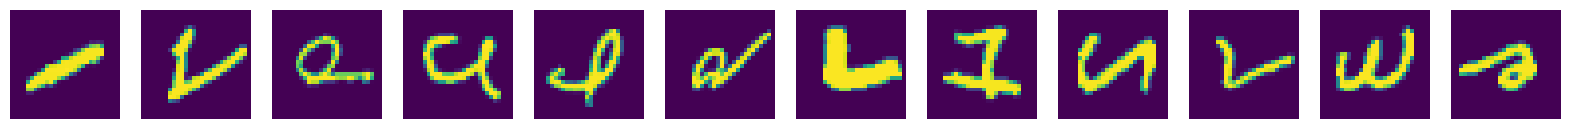

In [8]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Call plot with pred_label_batch = labels_batch before training
plot_examples(image_batch,labels_batch,labels_batch)

# Define VAE Model

In the code cells below you can define your VAE model.

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [10]:
#############################
###  You VAE model here #####
#############################
# Class for VAE Encoder.Dimensions for input image hidden layerts and latent dims

class vae_Encoder(nn.Module):
    def __init__(self,image_dim,hidden_dim,latentSpace_dim):
        super().__init__()

# Sequential layers for the encoder
        self.fc = nn.Sequential(
            nn.Linear(image_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,latentSpace_dim))
# Layer to use for mu and sigma
        self.LinearLayer = nn.Linear(latentSpace_dim,latentSpace_dim)

# A normal distribution of mean 0 and standard deviation of 1        
        self.NormalDist = torch.distributions.Normal(0,1)

    def forward(self,x):
# Flatten the image tensor (batch size, 1,xsize,ysize) to (batch size,x*xsize*ysize) 
        x = torch.flatten(x,start_dim=1)

        x = self.fc(x)
        
# Get the mean
        mu = self.LinearLayer(x)
# get the variance
        sigma = torch.exp(self.LinearLayer(x))
# Get z by multiplying the varuance and adding the mean.(reparameterization)
        z = mu + sigma*self.NormalDist.sample(mu.shape).to(device)
                          
        return z,mu,sigma
        

class vae_Decoder(nn.Module):
    def __init__(self,image_dim,hidden_dim,latentSpace_dim):
        super().__init__()
# Sequential layers for the decoder
        self.fc = nn.Sequential(
            nn.Linear(latentSpace_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,image_dim))

    def forward(self,x):
        x = self.fc(x)
        x = nn.functional.sigmoid(x)            
        return x

class VAE(nn.Module):
    def __init__(self,image_dim,hidden_dim,latentSpace_dim):
        super().__init__()
        self.encoder = vae_Encoder(image_dim,hidden_dim,latentSpace_dim)
        self.decoder = vae_Decoder(image_dim,hidden_dim,latentSpace_dim)
        

    def forward(self,x):
        z,mu,sigma = self.encoder(x)
        x_hat = self.decoder(z)
        x_hat = torch.unflatten(x_hat,1,(28,28))
        return x_hat,mu,sigma



Model Summary.

In [11]:
inputDims = 784
HiddenDims = 384
LatentDims = 384
model = VAE(inputDims,HiddenDims,LatentDims)
print(model)

VAE(
  (encoder): vae_Encoder(
    (fc): Sequential(
      (0): Linear(in_features=784, out_features=384, bias=True)
      (1): ReLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
      (3): ReLU()
      (4): Linear(in_features=384, out_features=384, bias=True)
    )
    (LinearLayer): Linear(in_features=384, out_features=384, bias=True)
  )
  (decoder): vae_Decoder(
    (fc): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
      (3): ReLU()
      (4): Linear(in_features=384, out_features=784, bias=True)
    )
  )
)


In [12]:
from torchinfo import summary
# Ensure input size is correct
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [128, 28, 28]             --
├─vae_Encoder: 1-1                       [128, 384]                --
│    └─Sequential: 2-1                   [128, 384]                --
│    │    └─Linear: 3-1                  [128, 384]                301,440
│    │    └─ReLU: 3-2                    [128, 384]                --
│    │    └─Linear: 3-3                  [128, 384]                147,840
│    │    └─ReLU: 3-4                    [128, 384]                --
│    │    └─Linear: 3-5                  [128, 384]                147,840
│    └─Linear: 2-2                       [128, 384]                147,840
│    └─Linear: 2-3                       [128, 384]                (recursive)
├─vae_Decoder: 1-2                       [128, 784]                --
│    └─Sequential: 2-4                   [128, 784]                --
│    │    └─Linear: 3-6                  [128, 384]     

# Optimisation & Training Loop

In the code cell below you can include the loss function for the VAE:

* In order to retain compatibility with the training loop below (you may write your own loop if you wish) it is recommended to create a loss function that returns the total loss, the KL-Divergence loss and reconstruction loss terms separately.
* The basic ADAM optimiser should be sufficient to train the VAE.

In [13]:
def loss_fn(x,xhat,mu,sigma):


# Formula for Reconstruction loss using binary cross entropy    
    rec_loss = nn.functional.binary_cross_entropy(xhat.view(-1,784),x.view(-1,784),reduction = "sum")

    # KL Loss
    KL_loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
# Total loss
    total_loss = KL_loss + rec_loss
    
    return total_loss,KL_loss, rec_loss

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb))


In [15]:


# Amend Run names based on hyperparamters and add date & time
run_name = 'VAE Loss Run 1'
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f"runs/{run_name}_{timestamp}"
writer = SummaryWriter(log_dir=log_dir)


A sample training loop is given below, it should be relatively straightforward to incorporate your model into this loop by just modifying the train_step.
* Note that input images are shape [batch_size,1,28,28]. The output of your model should be the same shape.
* The train step outputs the total loss, the KL-divergence loss, the reconstruction loss aswell as the reconstructed sample. (Returning these values will allow you to plot the losses and write to the tensorboard with the code below.)

In [16]:

# Train step that operates on each batch
def train_step(x):
        model.train(True)
        #############################
        # Your code here
        #############################
# Run the model
        x_hat,mu,sigma = model(x)
# Calculate the loss
        loss,kl_loss,rec_loss = loss_fn(x,x_hat,mu,sigma)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        return loss, kl_loss, rec_loss,x_hat


# Create a class to handle metrics with methods to accumulate the loss/accuracy
# and print average over interval of iterations
class tt_metrics:

  def __init__(self,dataloader,type,n_iter=100000):

        self.dataloader = dataloader
        self.num_batches = len(dataloader)         # batches in epoch
        self.num_samples = len(dataloader.dataset) # samples in epoch
        self.avg_tot_loss = 0
        self.avg_rec_loss = 0
        self.avg_kl_loss = 0
        self.type = type
        # Determine number of iterations / samples for metric calculation
        # number of iterations can be less than (max) iterations in an epoch
        # max is number of iterations in epoch.
        self.n_iter = min(n_iter,self.num_batches)

        # Intialise accumulators for determining loss and accuracy
        self.running_tot_loss = 0.0
        self.running_kl_loss = 0.0
        self.running_rec_loss = 0.0

  def update_acc(self, tot_loss,rec_loss,kl_loss):
        # Accumulate loss
        self.running_tot_loss += tot_loss.item()
        self.running_kl_loss += kl_loss.item()
        self.running_rec_loss += rec_loss.item()

  def calc_metrics(self,batch_size):
            # Where n_iter is interval calculating average over
            # and type is a string denoting, train val or test
            self.avg_tot_loss = self.running_tot_loss / self.n_iter   # divide by number of batches are computing over
            self.avg_kl_loss = self.running_kl_loss / self.n_iter
            self.avg_rec_loss = self.running_rec_loss / self.n_iter
            # Reset accumulation
            self.running_tot_loss = 0.0
            self.running_kl_loss = 0.0
            self.running_rec_loss = 0.0

def tb_write(train_metrics,val_metrics,epoch,i):

      # Calculate metrics for Train & Test
      train_metrics.calc_metrics(batch_size)
      val_metrics.calc_metrics(batch_size)

      # Print intermediate results
      print('Epoch {}'.format(epoch),' Batch {}'.format(i + 1))
      print(f"{train_metrics.type} Error: \n Total Loss: {(train_metrics.avg_tot_loss):>3f}, KL loss: {train_metrics.avg_kl_loss:>3f}, Rec loss: {train_metrics.avg_rec_loss:>3f} \n")


      # Log the running loss averaged per batch
      writer.add_scalars('Total Loss',
                            { f"{train_metrics.type}/Tot_Loss" : train_metrics.avg_tot_loss},
                            epoch * len(train_dataloader) + i)
      writer.add_scalars('Reconstruction Loss',
                            {f"{train_metrics.type}/Rec_Loss" : train_metrics.avg_rec_loss},
                            epoch * len(train_dataloader) + i)
      writer.add_scalars('KL Loss',
                            {f"{train_metrics.type}/KL_Loss" : train_metrics.avg_kl_loss},
                            epoch * len(train_dataloader) + i)

# Main training & evaluation loop
def train_eval_loop(n_epochs,n_iter):
    # Where n_epochs is the number of epochs and n_iter can be set to
    # a value less than number iterations in an epoch if required

    for epoch in range(n_epochs):  # loop over the dataset multiple times
      # Intialise metrics
      train_metrics = tt_metrics(train_dataloader,type='Train',n_iter=100)
      val_metrics = tt_metrics(test_dataloader,type='Test')

      # Enumerate over the training data
      for i, data in enumerate(train_dataloader, 0):
        # Extract images and labels and transfer to device
        x, labels = data
        x = x.to(device)

        # Run train step (returns loss outputs for metrics)
        loss, kl_loss, rec_loss,x_hat = train_step(x)

        # update metrics
        train_metrics.update_acc(loss,kl_loss, rec_loss)

        # Write outputs after fixed interval
        if i % n_iter == n_iter-1:    # Every n mini-batches...

            # Calculate and Print metrics (metrics reset after calculation)
            tb_write(train_metrics,val_metrics,epoch,i)

      # Apply Schedule at end of each epoch.
      #lr_scheduler.step(val_metrics.avg_loss)
      #print('LR value = ',lr_scheduler.get_last_lr())


writer.flush()

In [18]:
n_epochs=10
n_iter=200
train_eval_loop(n_epochs,n_iter)

Epoch 0  Batch 200
Train Error: 
 Total Loss: 51595.568477, KL loss: 25085.825352, Rec loss: 26509.742979 

Epoch 0  Batch 400
Train Error: 
 Total Loss: 51482.733809, KL loss: 24931.473291, Rec loss: 26551.260586 

Epoch 1  Batch 200
Train Error: 
 Total Loss: 51243.441113, KL loss: 24693.880410, Rec loss: 26549.560576 

Epoch 1  Batch 400
Train Error: 
 Total Loss: 51226.590352, KL loss: 24665.709951, Rec loss: 26560.880293 

Epoch 2  Batch 200
Train Error: 
 Total Loss: 51071.432090, KL loss: 24492.640029, Rec loss: 26578.792246 

Epoch 2  Batch 400
Train Error: 
 Total Loss: 50923.416406, KL loss: 24332.080459, Rec loss: 26591.335889 

Epoch 3  Batch 200
Train Error: 
 Total Loss: 50982.043672, KL loss: 24350.623203, Rec loss: 26631.420488 

Epoch 3  Batch 400
Train Error: 
 Total Loss: 50676.394141, KL loss: 24088.228145, Rec loss: 26588.166152 

Epoch 4  Batch 200
Train Error: 
 Total Loss: 50706.586914, KL loss: 24070.448252, Rec loss: 26636.138643 

Epoch 4  Batch 400
Train Err

Note when r[unning colab container on docker, tensorboard](https://leimao.github.io/blog/TensorBoard-On-Docker/) will open on webpage: http://127.0.0.1:6006/

In [19]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --bind_all

## Tensorboard Loss Charts

Total Loss
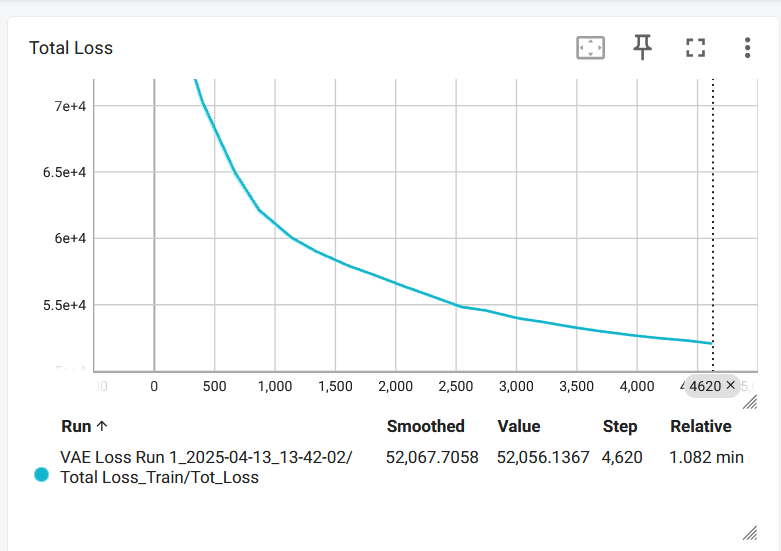

KL Loss
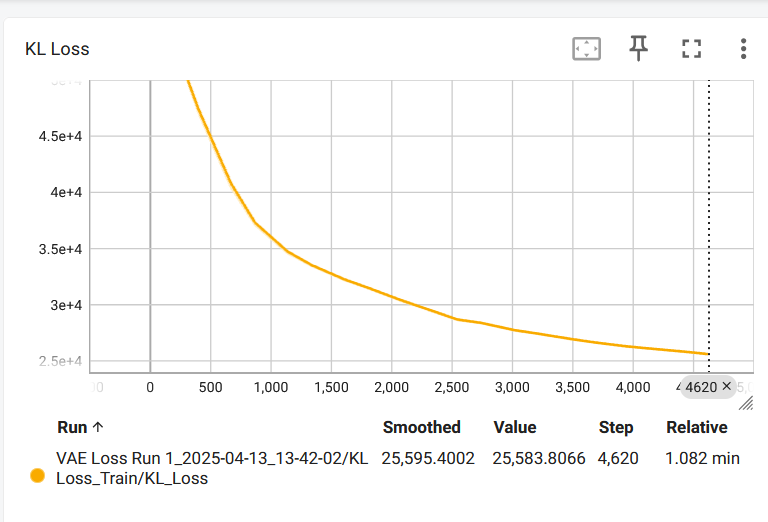

Reconstruction Loss
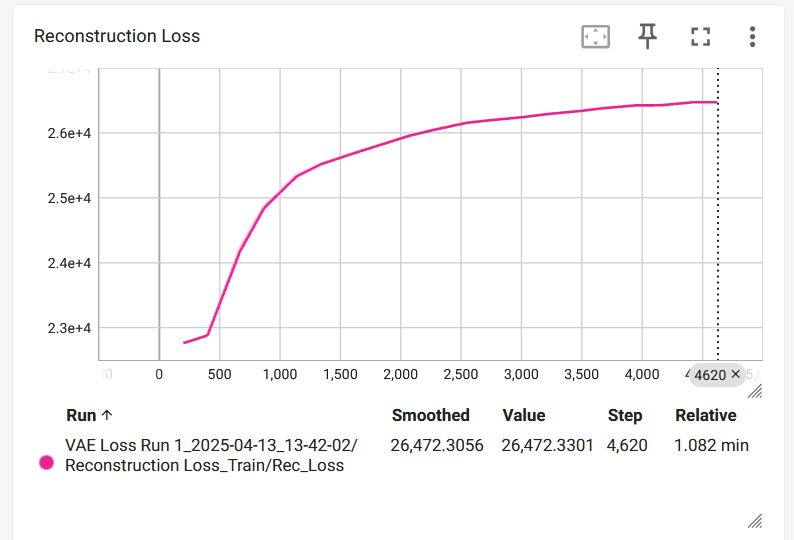


# Evaluate Model

1. You can test reconstruction ability of your model by plotting the output value against the input images. Note that input images are shape [batch_size,1,28,28]. The output of your model should be the same shape.

torch.Size([128, 1, 28, 28])


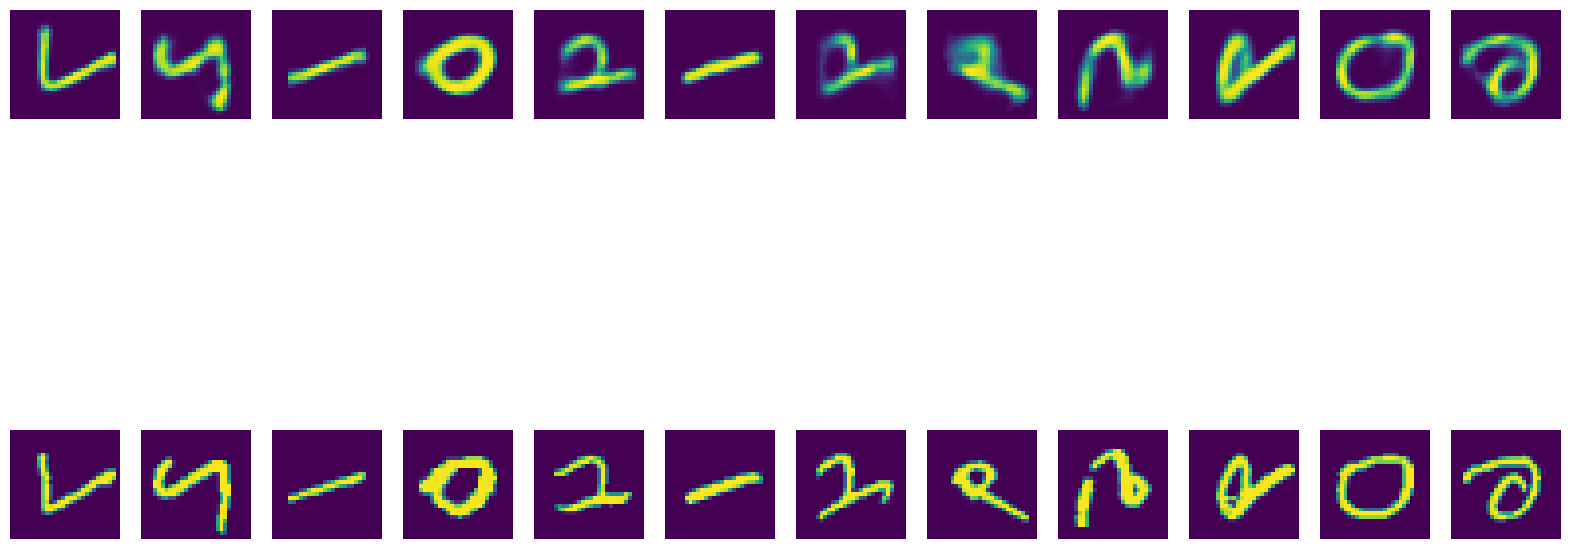

In [20]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
###################################################
# You code to call model and return reconstructed batch
###################################################

# Send the data to the GPU
image_batch = image_batch.to(device)
print(image_batch.shape)
# Run the model and return the reconstructed batch of images.
rec_batch,mu,sigma = model(image_batch)
rec_batch = torch.unflatten(rec_batch,1,(1,28))





# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(2,n_plots,figsize=(20,10))


for image in rec_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).detach().numpy() # return image to cpu for display and permute to channels last
  gt_image =  torch.permute(image_batch[i].to('cpu'),(2,1,0)).detach().numpy() # return image to cpu for display and permute to channels last

  disp_image = np.clip(disp_image, 0, 1)
  axarr[0,i].imshow(disp_image[:,:,:])
  axarr[0,i].axis("off")
  axarr[1,i].imshow(gt_image[:,:,:])
  axarr[1,i].axis("off")

  i = i+1

2. Plot some generated images by applying random values to the decoder.
* Note: You can access the decoder part of your model directly with `model.decoder` (or equivalent depending on the setup of your model)

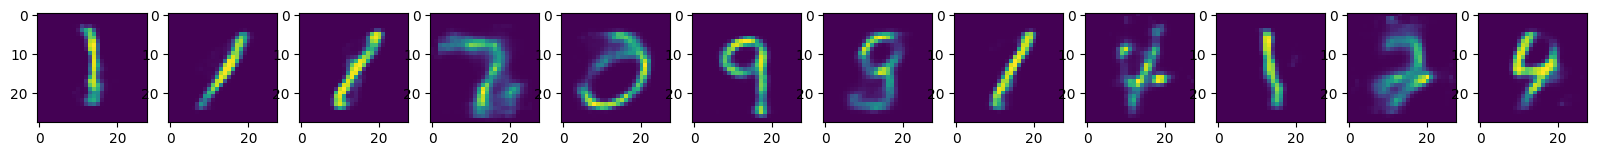

In [21]:

# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))


    ###################################################################
    # Your code here to apply sampled noise input to
    # decoder and return generated image (note model will return 1 batch)
    ##################################################################
# Generate a torch tensor with dimensions latenddims X latentdims populated with random values with mean 0 and std of 1
generated_images = torch.randn((LatentDims,LatentDims)).to(device)
# Generate the images by running thru the decoder model
generated_images = model.decoder(generated_images)
generated_images = torch.unflatten(generated_images,1,(28,28))
for i in range(n_plots):
    axarr[i].imshow(generated_images[i].cpu().detach().numpy().reshape(28,28))

3. Visualise the latent space of the cluster.
* Techniques from [scikit learn are suitable for this](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)


In [22]:
# Sequential layers for the encoder


torch.Size([128, 384])
torch.Size([128, 384])
torch.Size([128, 384])
torch.Size([256, 384])
torch.Size([128, 384])
torch.Size([384, 384])
torch.Size([128, 384])
torch.Size([512, 384])
torch.Size([128, 384])
torch.Size([640, 384])
torch.Size([128, 384])
torch.Size([768, 384])
torch.Size([128, 384])
torch.Size([896, 384])
torch.Size([128, 384])
torch.Size([1024, 384])
torch.Size([128, 384])
torch.Size([1152, 384])
torch.Size([128, 384])
torch.Size([1280, 384])
torch.Size([128, 384])
torch.Size([1408, 384])
torch.Size([128, 384])
torch.Size([1536, 384])
torch.Size([128, 384])
torch.Size([1664, 384])
torch.Size([128, 384])
torch.Size([1792, 384])
torch.Size([128, 384])
torch.Size([1920, 384])
torch.Size([128, 384])
torch.Size([2048, 384])
torch.Size([128, 384])
torch.Size([2176, 384])
torch.Size([128, 384])
torch.Size([2304, 384])
torch.Size([128, 384])
torch.Size([2432, 384])
torch.Size([128, 384])
torch.Size([2560, 384])
torch.Size([128, 384])
torch.Size([2688, 384])
torch.Size([128, 384

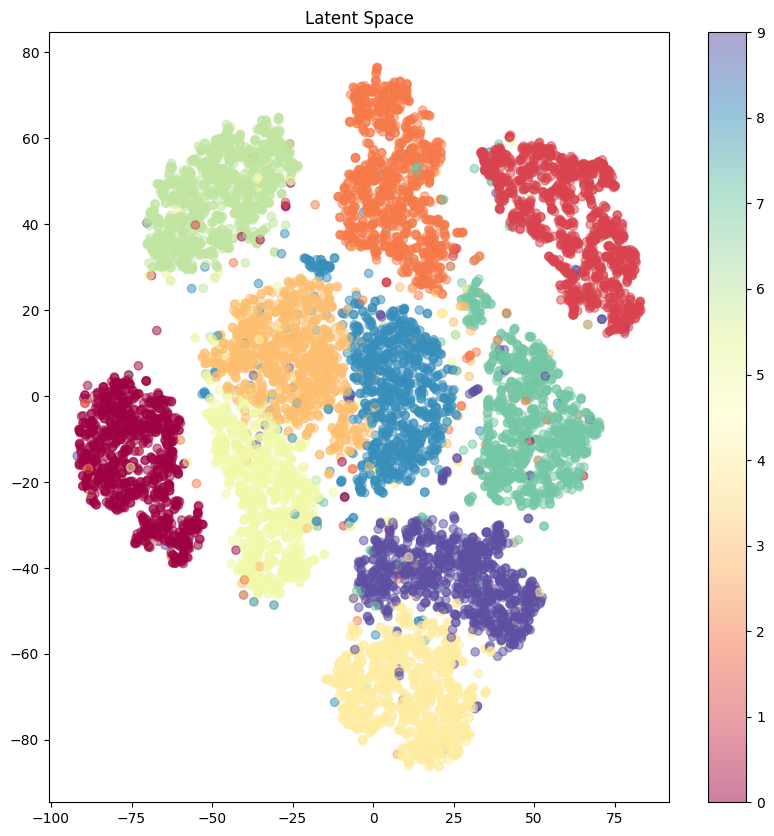

In [26]:
from sklearn.manifold import TSNE

# Function to plot the latent Space
def plot_latentSpace(X,labels,Title):
    print("labels ",labels)
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels,
                      cmap='Spectral',alpha=0.5)
    plt.colorbar(scatter)
    plt.title(Title)
    plt.show()
    



tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
# Empty Torch tensor with size LatentDims
latent_space = torch.empty(0,LatentDims).to(device)
# List of image labels
image_labels = []
model.eval()

# Loop through image batchs in the test data set
for image_batch,labels_batch in test_dataloader:
    image_batch = image_batch.to(device)
# Run encoder and return z,mu,sigma
    z,mu,sigma = model.encoder(image_batch)
    print(mu.shape)
# Add mu to latent space tensor
    latent_space = torch.cat((latent_space,mu),dim=0)
    print(latent_space.shape)
# add batch of labels to image labels
    image_labels.append(labels_batch)

#Convert torch tensors to Numpy arrays.
latent_space= torch.Tensor.detach(latent_space.to("cpu")).numpy()
image_labels = torch.cat(image_labels,dim=0).numpy()
# Run the TSNE transform
latent_tsne = tsne.fit_transform(latent_space)
# Plot the Latent Space
plot_latentSpace(latent_tsne,image_labels,"Latent Space",)

# Reflection

This was another interesting assignment and provided the opportunity to investigate approaches to generative models. There were a number of challenges with building the correct encoder/decoder model and also getting the loss functions correct. Feedback on the forum from Kevin/Alina/Sushil helped with resolving those issues. 

While there was alot covered in the assignment i think there are several further interesting areas of investigation with regard to generative models and also even looking at the VAE models in more detail and understanding how the approach would work outside the mnnist dataset.  